<h1>Batik image classification using Random Forest</h1>
<p>Author: HendryHB</p>

<h3>Random (Decision) Forest</h3>

<p>
    Random Forest is an ensemble learning method primarily used for classification and regression tasks. It was developed by Tin Kam Ho in 1995. This technique combines multiple decision trees to produce a more accurate and stable prediction compared to individual decision trees.[1]

<strong>Random Forest Conceptual</strong>
<ol>
    <li>Dataset Splitting</li>
    The Random Forest algorithm starts by creating multiple subsets (bootstrapped samples) of the original dataset. Each subset is generated by randomly sampling the data with replacement.
    <li>Building Decision Trees</li>
    For each bootstrapped sample, a decision tree is built. However, unlike traditional decision trees, Random Forest introduces two key modifications:
    <ol><li><strong>Random Feature Selection:</strong> At each node of the tree, a random subset of features is selected. The best feature for splitting the data is chosen from this subset, not from the full feature set.</li>
        <li><strong>Bootstrapped Samples:</strong> Each tree is built using a different subset of the data, ensuring diversity among the trees.</li></ol>
    <li>Tree Independence</li>
    Each tree in the forest is grown independently and without pruning. This independence helps in capturing different patterns from the data, leading to a more robust model.
    <li>Aggregating Results</li>
        <ul><li>For classification tasks, each tree in the forest votes for a class, and the class with the majority votes is selected as the final prediction.</li>
            <li>For regression tasks, the average of the outputs from all trees is computed to produce the final prediction.</li></ul>
[2]</ol>

<img src="https://github.com/hendryhb/kecakbali/blob/main/rf_1.png?raw=true">

<strong>Bibliography:</strong><br>
[1] Tin Kam Ho, “Random decision forests,” in Proceedings of 3rd International Conference on Document Analysis and Recognition, Montreal, Que., Canada: IEEE Comput. Soc. Press, 1995, pp. 278–282. doi: 10.1109/ICDAR.1995.598994.<br>
[2] S. Raschka and V. Mirjalili, Python machine learning: machine learning and deep learning with Python, scikit-learn, and TensorFlow 2, Third edition. in Expert insight. Birmingham Mumbai: Packt, 2019.
</p>

In [1]:
from google.colab import drive  # for google colab
import zipfile  # for google colab
import sys
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical
from keras.preprocessing.image import array_to_img

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

np.random.seed(42)

In [104]:
drive.mount('/content/drive')  # for google colab

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/raw_batik_v2.1.zip") as zip_ref:  # for colab
  zip_ref.extractall("./")

# Constants

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_CHANNELS = 3
BATCH_SIZE = 32

# Data Gathering

In [3]:
# Directory containing the data - fetching dataset from google drive
DATA_DIR = "/content/raw_batik_v2.1.zip"

common_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    rescale=1./255 
)

# Set up data generators for training, validation, and testing
train_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Set the target image size
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'  # For multi classes
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'
)

Found 640 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


# Data Exploration

## Train Dataset

<p><code>.n</code> is an attribute to the total count of images found and <code>.num_classes</code> is the number of subdirectories found (classes)</p>

In [4]:
x_train_images = train_generator.n
y_train_classes = train_generator.num_classes
print(f"Number of images: {train_generator.n}, Number of classes:{train_generator.num_classes}")

Number of images: 640, Number of classes:20


In [5]:
x_train_all = []
y_train_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_train_images // BATCH_SIZE ):
    x_batch, y_batch = next(train_generator)
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenate
x_train = np.concatenate(x_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Display the shapes of x and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (640, 224, 224, 3)
y_train shape: (640, 20)


## Test Dataset

<p><code>.n</code> is an attribute to the total count of images found and <code>.num_classes</code> is the number of subdirectories found (classes)</p>

In [8]:
x_test_images = test_generator.n
y_test_classes = test_generator.num_classes
print(f"Number of images: {test_generator.n}, Number of classes:{test_generator.num_classes}")

Number of images: 160, Number of classes:20


In [9]:
x_test_all = []
y_test_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_test_images // BATCH_SIZE):
    x_test_batch, y_test_batch = next(test_generator)
    x_test_all.append(x_test_batch)
    y_test_all.append(y_test_batch)

# Concatenate
x_test = np.concatenate(x_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Display the shapes of x and y_train
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (160, 224, 224, 3)
y_test shape: (160, 20)


In [10]:
# Get class indices and create a reverse mapping
x_test_class_indices = test_generator.class_indices
y_test_index_to_class = {v: k for k, v in x_test_class_indices.items()}

In [11]:
# Define test labels that could be reused on later stage
test_labels = [y_test_index_to_class[idx] for idx in range(len(y_test_index_to_class))]
print("Class names:", test_labels)

Class names: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


<h1>Flattening the images for RandomForestClassifier</h1>
<p>
    <ul>
        <li><code>x_train and <code>x_test</code> are flattened since <code>RandomForestClassifier</code> in scikit-learn expects 2D input.</li>
        <li>Labels <code>y_train</code> and <code>y_test</code> are converted from one-hot encoded format to class indices using np.argmax.</li></ul>
</p>

In [12]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [13]:
# Convert one-hot encoded labels to integer labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Random Forest Classification (Training)
<p>
    <ol>
        <li>n_estimators<ul>
            <li>Purpose: It determines the <strong>number of decision trees in the random forest</strong> and in this case it consists of 10 trees. Each decision tree will be trained on a random subset of the data. The value chosen for <code>n_estimators</code> can significantly impact the performance, robustness, and computational efficiency on the model [3].</li>
            <li>Impact: More trees generally improve the model’s performance up to a point, but they also increase computational cost and memory usage.
            </ul></li><br>
        <li>Number of Classes<ul>
            <li>Dataset: There are 20 classes for classification.</li>
            <li>Handling Classes: The class_mode='categorical' parameter in the data generators ensures that the labels are one-hot encoded, making them suitable for a multi-class classification problem.</li></ul></li><br>
        <li><code>random_state</code> and <code>np.random.seed</code><ul> 
            <li>random_state (in RandomForestClassifier): Controls the randomness of the bootstrapping of the samples and the feature selection during tree splitting. Setting it ensures reproducibility.</li>
            <li>np.random.seed(42): Sets the seed for NumPy's random number generator, ensuring that any NumPy random operations are reproducible. This is separate from the random state in </code>RandomForestClassifier</code>.</li></ul></li>
    </ol>
</p>

<h3>Summary</h3>
<ol>
    <li><strong>No Conflict</strong>: <code>np.random.seed(42)</code> and <code>random_state=42</code> or <code>random_state=any_number</code> do not conflict as they control different sources of randomness.</li>
    <li><strong>Same Seed</strong>: It is fine use the same seed for both if you want consistent randomness control across the code.</li>
    <li><strong>Different <code>random_state</code></strong>: Using <code>random_state=42</code> instead of 30 changes the specific random processes within the random forest but maintains reproducibility.</li>
</ol>

<h3>Bibliography</h3><br>
<p>[3] T. Amr, Hands-on machine learning with scikit-learn and scientific Python toolkits: a practical guide to implementing supervised and unsupervised machine learning algorithms in Python. Birmingham Mumbai: Packt, 2020.</p>

In [14]:
# Instantiate model with 200 decision trees and random_state=42
model = RandomForestClassifier(n_estimators=200, max_features=64, random_state=42)

In [15]:
# Fit the model
model.fit(x_train_flat, y_train_int)

RandomForestClassifier(max_depth=5, max_features=64, n_estimators=200,
                       random_state=42)

# Evaluation and Prediction

In [16]:
# Predict on test data
y_pred = model.predict(x_test_flat)

In [17]:
# # Evaluate the model
accuracy = np.mean(y_pred == y_test_int)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 21.88%


<h4>To compare <code>np.mean</code> vs <code>metrics.accuracy_score</code></h4>

In [2]:
print ("Accuracy = ", metrics.accuracy_score(y_test_int, y_pred))

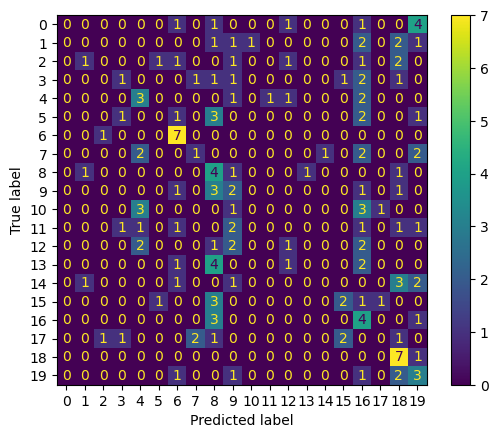

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)

In [20]:
classify_report = classification_report(y_test_int, y_pred, target_names=test_labels)
print(classify_report)

                            precision    recall  f1-score   support

           Aceh_Pintu_Aceh       0.00      0.00      0.00         8
               Bali_Barong       0.00      0.00      0.00         8
                Bali_Merak       0.00      0.00      0.00         8
           DKI_Ondel_Ondel       0.25      0.12      0.17         8
     JawaBarat_Megamendung       0.27      0.38      0.32         8
           JawaTimur_Pring       0.00      0.00      0.00         8
          Kalimantan_Dayak       0.47      0.88      0.61         8
             Lampung_Gajah       0.25      0.12      0.17         8
        Madura_Mataketeran       0.16      0.50      0.24         8
               Maluku_Pala       0.14      0.25      0.18         8
               NTB_Lumbung       0.00      0.00      0.00         8
               Papua_Asmat       0.00      0.00      0.00         8
         Papua_Cendrawasih       0.20      0.12      0.15         8
                Papua_Tifa       0.00      0.00

/Users/hendrysi/anaconda3/envs/batik/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/hendrysi/anaconda3/envs/batik/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/hendrysi/anaconda3/envs/batik/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<h1>Summary</h1>
    <p>Random Forest is a powerful ensemble method that leverages the strengths of multiple decision trees. By incorporating randomness both in data sampling and feature selection, it creates diverse models.</br>
    In order to fine-tune Random Forest Model please see <a href="https://github.com/hendryhb/kecakbali/blob/main/hyperparams_rf_fine_tuning.ipynb">hyperparams_rf_fine_tuning</a> notebook.</br> 
    For further reading about RandomForestClassifier could be found in <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Sklearn documentation</a>.<br> 
    </p>